**TBATS**: periodo di 2 anni più tre mesi 2022, osservazioni trimestrali, due stagionalità: settimanale e annuale

**T**rigonometric seasonality, **B**ox-Cox transformation, **A**RMA errors, **T**rend and **S**easonal components.

![tbats](https://miro.medium.com/max/1050/1*yfruZnSYsNt1X1uyag46eQ.png)

Each seasonality is modeled by a trigonometric representation based on Fourier series. One major advantage of this approach is that it requires only 2 seed states regardless of the length of period. Another advantage is the ability to model seasonal effects of non-integer lengths. For example, given a series of daily observations, one can model leap years with a season of length 365.25.

**BATS** differs from TBATS only in the way it models seasonal effects. In BATS we have a more traditional approach where each seasonality is modeled by:

![bats](https://miro.medium.com/max/1050/1*D8KY2jQRmVRLHY5f4RNqKA.png)

This implies that BATS can only model integer period lengths. Approach taken in BATS requires m_i seed states for season i, if this season is long the model may become intractable.

How Does TBATS Choose The Final Model

Under the hood TBATS will consider various alternatives and fit quite a few models. It will consider models:
- with Box-Cox transformation and without it.
- with and without Trend
- with and without Trend Damping
- with and without ARMA(p,q) process used to model residuals
- non-seasonal model
- various amounts of harmonics used to model seasonal effects

The final model will be chosen using Akaike information criterion (AIC).

In [1]:
import pandas as pd
import numpy as np
import datetime as dt

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from tbats import BATS, TBATS

In [3]:
df = pd.read_csv('../data/calcio_mensile.csv')
df.head()

,Datetime,totale
0,2014-01-31,17431.77
1,2014-02-28,95685.57
2,2014-03-31,194684.14
3,2014-04-30,363993.71
4,2014-05-31,296445.76


In [5]:
df = df.rename(columns={"Datetime": "data"})
df['data'] = pd.to_datetime(df['data'])

In [6]:
df.dtypes

data      datetime64[ns]
totale           float64
dtype: object

In [7]:
df.head()

,data,totale
0,2014-01-31,17431.77
1,2014-02-28,95685.57
2,2014-03-31,194684.14
3,2014-04-30,363993.71
4,2014-05-31,296445.76


In [8]:
mask = (df['data'] < '2022-01-01')

In [9]:
df = df.loc[mask]

In [10]:
df

,data,totale
0,2014-01-31,17431.77
1,2014-02-28,95685.57
2,2014-03-31,194684.14
3,2014-04-30,363993.71
4,2014-05-31,296445.76
...,...,...
91,2021-08-31,342640.16
92,2021-09-30,523938.53
93,2021-10-31,488834.88
94,2021-11-30,469943.62


In [11]:
df = df.set_index('data')
df.head()

,totale
data,
2014-01-31,17431.77
2014-02-28,95685.57
2014-03-31,194684.14
2014-04-30,363993.71
2014-05-31,296445.76


In [12]:
df = df[['totale']]
df.head()

,totale
data,
2014-01-31,17431.77
2014-02-28,95685.57
2014-03-31,194684.14
2014-04-30,363993.71
2014-05-31,296445.76


In [13]:
y = df['totale']

In [14]:
len(y)

96

In [15]:
len(y) / 100 * 20

19.2

In [16]:
steps = 19

y_to_train = y.iloc[:(len(y)-steps)]
y_to_test = y.iloc[(len(y)-steps):] # last year for testing

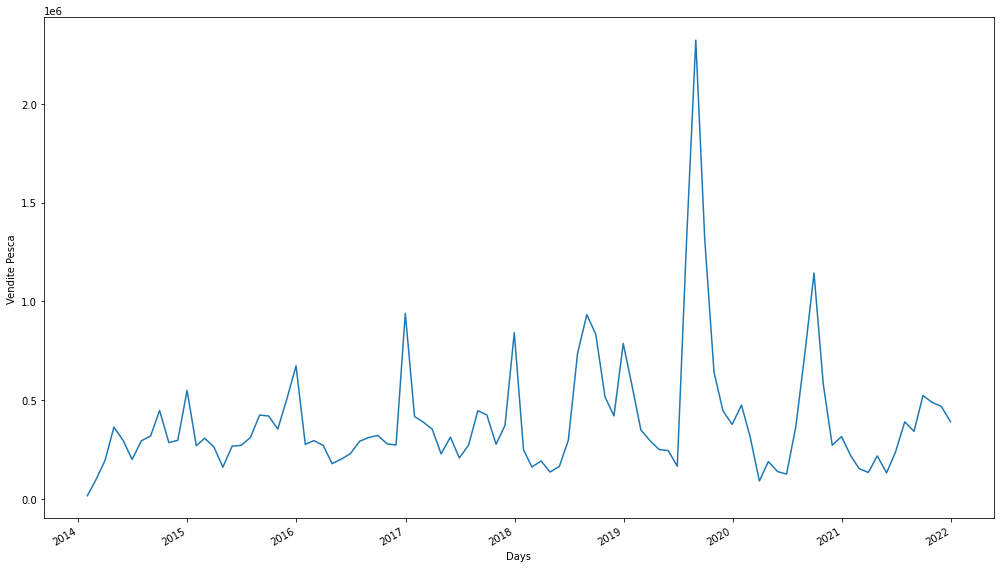

In [17]:
fig, ax = plt.subplots(figsize=(14, 8))
ax.plot(df['totale'])
ax.set_xlabel('Days')
ax.set_ylabel('Vendite Pesca')

fig.autofmt_xdate()

plt.tight_layout()
plt.show()

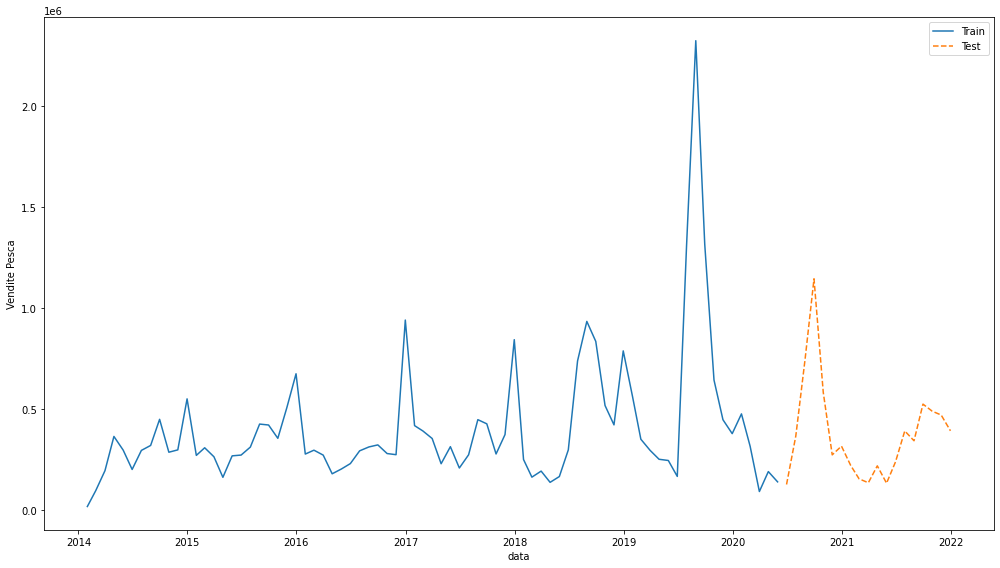

In [18]:
fig, ax = plt.subplots(figsize=(14, 8))

ax.plot(y_to_train, ls='-', label='Train')
ax.plot(y_to_test, ls='--', label='Test')
ax.set_xlabel('data')
ax.set_ylabel('Vendite Pesca')

ax.legend(loc='best')
plt.tight_layout()
plt.show()

Da questa figura dovremmo individuare pattern di stagionalità. (Ad esempio settimanale, mensile, annuale, ecc.)

Before we implement our more complex BATS and TBATS models, it’s always a good idea to have a baseline model. That way, we can determine if our more complex forecasting methods are actually performant.

In [19]:
y_pred_baseline = y_to_train[-steps:].values

In [20]:
# Fit the model
estimator = TBATS()
model = estimator.fit(y_to_train)

# Forecast 365 days ahead
y_forecast = model.forecast(steps)

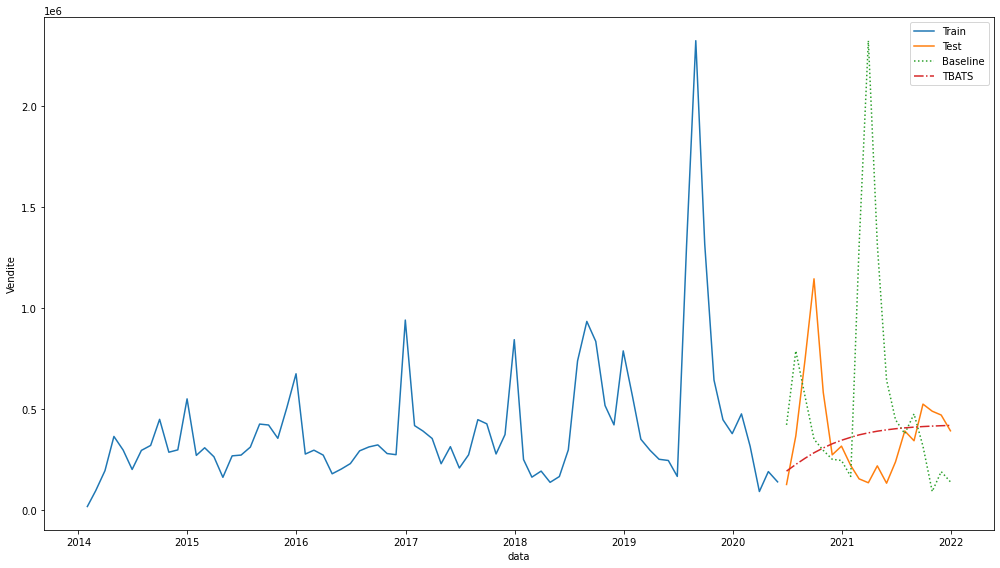

In [21]:
fig, ax = plt.subplots(figsize=(14, 8))
ax.plot(y_to_train, ls='-', label='Train')
ax.plot(y_to_test, ls='-', label='Test')
ax.plot(y_to_test.index, y_pred_baseline, ls=':', label='Baseline')
ax.plot(y_to_test.index, y_forecast, ls='-.', label='TBATS')

ax.set_xlabel('data')
ax.set_ylabel('Vendite')

ax.legend(loc='best')
plt.tight_layout()
plt.show()

MAPE

In [22]:
print('Did the model fit?', model.is_fitted)  # Model may fail to fit in edge-case situations
print('AIC', model.aic)  # may be np.inf

Did the model fit? True
AIC 2208.293174580908


In [23]:
# Short model summary
print('\n\nSUMMARY FUNCTION\n\n')
print(model.summary())



SUMMARY FUNCTION


Use Box-Cox: True
Use trend: True
Use damped trend: True
Seasonal periods: []
Seasonal harmonics []
ARMA errors (p, q): (0, 0)
Box-Cox Lambda 0.000000
Smoothing (Alpha): 0.714999
Trend (Beta): -0.188428
Damping Parameter (Phi): 0.800000
Seasonal Parameters (Gamma): []
AR coefficients []
MA coefficients []
Seed vector [11.92397601  0.22046631]

AIC 2208.293175


In [24]:
print('\n\nIN SAMPLE PREDICTIONS\n\n')
print('Original time series (5 first values)', model.y[:5])
print('Predictions (5 first values)', model.y_hat[:5])
print('Residuals (5 first values)', model.resid[:5])



IN SAMPLE PREDICTIONS


Original time series (5 first values) [ 17431.77  95685.57 194684.14 363993.71 296445.76]
Predictions (5 first values) [179934.65812066  55509.17327052 111964.05422654 196402.09899841
 317809.95927701]
Residuals (5 first values) [-162502.88812066   40176.39672948   82720.08577346  167591.61100159
  -21364.19927701]


In [25]:
steps = steps # one year in this case
y_forecasted = model.forecast(steps=steps)

In [26]:
print('\n\nFORECAST\n\n')
print('Values', y_forecasted)
print('MAE', np.mean(np.abs(y_forecasted - y_to_test)))



FORECAST


Values [192577.69825437 225565.6971755  255980.39566143 283239.374542
 307122.16687128 327670.38580278 345094.48265527 359698.53963134
 371825.52650164 381820.83507853 390010.19556633 396687.97000762
 402112.41885083 406505.33600932 410054.19807271 412915.58194479
 415219.05854805 417071.08846401 418558.65836015]
MAE 182332.14639914705


In [27]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_forecasted), np.array(y_to_test)
    return np.mean(np.abs((y_forecasted - y_to_test) / y_forecasted)) * 100

In [28]:
print('MAPE', mean_absolute_percentage_error(y_forecasted, y_to_test))

MAPE 58.05252181977807
